# Visualize Commute Routes
This notebook visualizes the commute routes generated by `main.py`. The routes are loaded from the `commute_routes.csv` file and plotted on an interactive map using Plotly.

In [44]:
import gcsfs
import pandas as pd
import plotly.express as px
import pytz
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import great_circle
from itertools import combinations

In [45]:
# Set your project ID and bucket name
project_id = 'dig-es-nws-gemini-projects'
bucket_name = 'marketplace-commutes'

# Initialize gcsfs
gcs = gcsfs.GCSFileSystem(project=project_id)

# List all CSV files in the bucket
files = gcs.glob(f'gs://{bucket_name}/*.csv')

print(files)

# Read all CSV files into a list of DataFrames
all_dfs = []
for f in files:
    df_temp = pd.read_csv(f"gs://{f}")
    # Extract timezone from filename
    filename = f.split('/')[-1]
    if 'atlantic' in filename:
        df_temp['timezone'] = 'America/Halifax'
    elif 'central' in filename:
        df_temp['timezone'] = 'America/Winnipeg'
    elif 'eastern' in filename:
        df_temp['timezone'] = 'America/Toronto'
    elif 'mountain' in filename:
        df_temp['timezone'] = 'America/Edmonton'
    elif 'pacific' in filename:
        df_temp['timezone'] = 'America/Vancouver'
    else:
        df_temp['timezone'] = 'UTC' # Default or handle as needed
    all_dfs.append(df_temp)


# Concatenate all DataFrames into a single DataFrame
df = pd.concat(all_dfs, ignore_index=True)

# Display the first few rows of the combined DataFrame
df.head()

['marketplace-commutes/commute_routes_atlantic.csv', 'marketplace-commutes/commute_routes_central.csv', 'marketplace-commutes/commute_routes_eastern.csv', 'marketplace-commutes/commute_routes_mountain.csv', 'marketplace-commutes/commute_routes_pacific.csv']


,origin,destination,travel_mode,distance_km,duration_min,warnings,line_geometry,timestamp,timezone
0,"Larry Uteck, Halifax",Hospital in Halifax,DRIVE,10.113,20,NaN,"LINESTRING (-63.67528 44.70207, -63.67451 44.7...",2025-08-26 20:10:05,America/Halifax
1,"Windsor Street, Halifax","St. Margaret's Bay Road, Halifax",DRIVE,5.678,13,NaN,"LINESTRING (-63.60553 44.65555, -63.60527 44.6...",2025-08-26 20:10:05,America/Halifax
2,"Armdale, Halifax","Bayers Lake, Halifax",DRIVE,7.775,12,NaN,"LINESTRING (-63.60788 44.63002, -63.60795 44.6...",2025-08-26 20:10:06,America/Halifax
3,"North End, Halifax","Macdonald Bridge, Halifax",BICYCLE,1.723,10,NaN,"LINESTRING (-63.60227 44.65962, -63.60234 44.6...",2025-08-26 20:10:06,America/Halifax
4,"Larry Uteck, Halifax",Hospital in Halifax,DRIVE,10.113,21,NaN,"LINESTRING (-63.67528 44.70207, -63.67451 44.7...",2025-08-26 20:20:05,America/Halifax


In [46]:
df["timezone"].unique()

array(['America/Halifax', 'America/Winnipeg', 'America/Toronto',
       'America/Edmonton', 'America/Vancouver'], dtype=object)

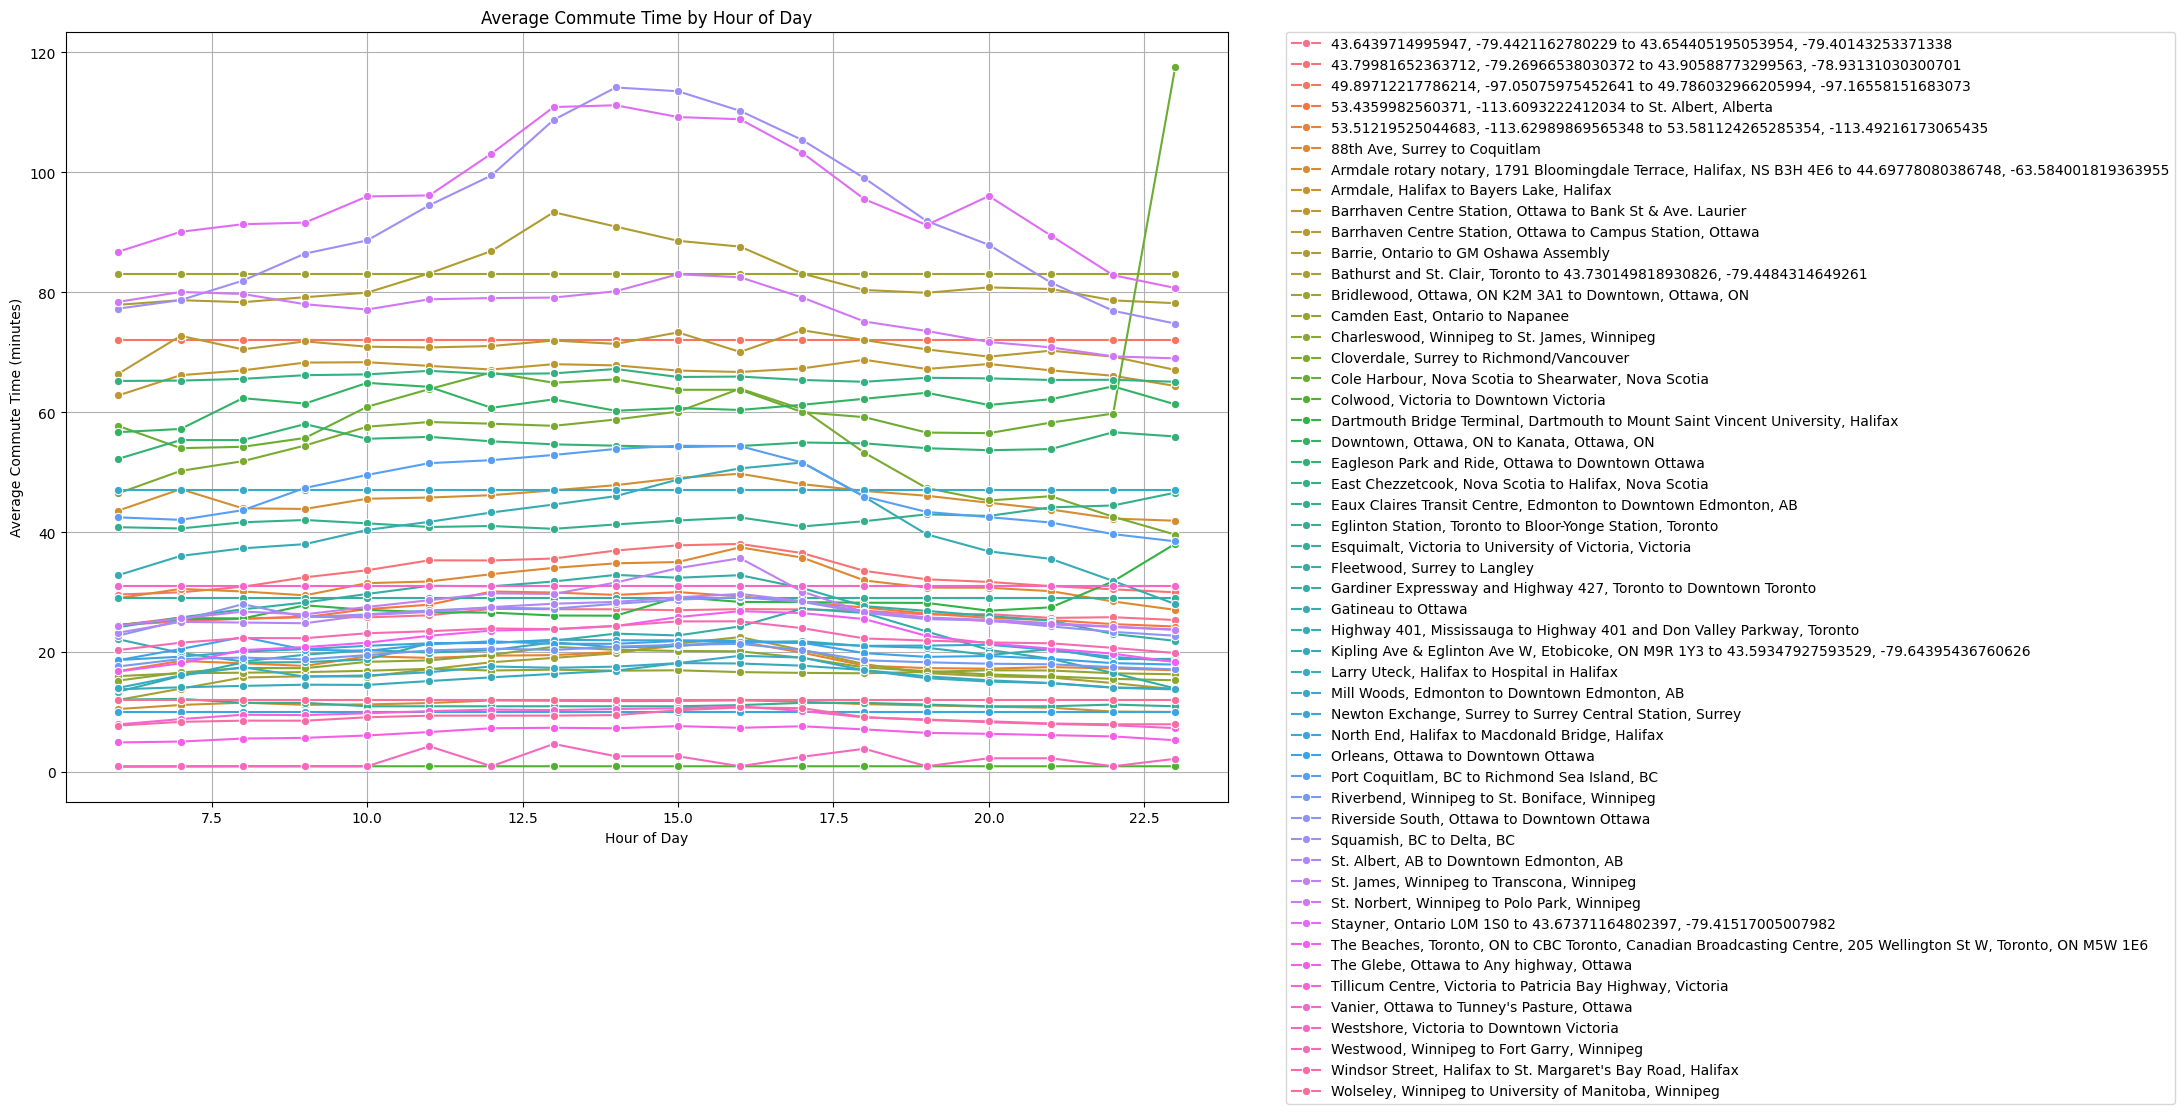

In [47]:
# --- Data Preparation ---

# Convert timestamp to datetime objects
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

# Create a unique identifier for each route
df['route_id'] = df['origin'] + ' to ' + df['destination']

# Localize timestamp and extract hour
df['timestamp_local'] = df.apply(lambda row: row['timestamp'].tz_convert(row['timezone']), axis=1)

df['hour'] = df['timestamp_local'].apply(lambda x: x.hour)

# --- Visualization ---
# Calculate average commute time per hour for each route
hourly_avg_df = df.groupby(['route_id', 'hour'])['duration_min'].mean().reset_index()

plt.figure(figsize=(15, 10))
sns.lineplot(data=hourly_avg_df, x='hour', y='duration_min', hue='route_id', marker='o')
plt.title('Average Commute Time by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Commute Time (minutes)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.show()

In [48]:
# Filter for off-peak hours
off_peak_df = df[~((df['hour'] >= 7) & (df['hour'] < 9) | (df['hour'] >= 17) & (df['hour'] < 19))]

# Calculate the median travel time for each route during off-peak hours
off_peak_stats = off_peak_df.groupby(['route_id', 'travel_mode'])['duration_min'].agg(['median', 'count']).reset_index()
off_peak_stats.columns = ['route_id', 'travel_mode', 'median_off_peak_duration_min', 'off_peak_data_points']

# Filter for peak hours
peak_df = df[((df['hour'] >= 7) & (df['hour'] < 9) | (df['hour'] >= 17) & (df['hour'] < 19))]

# Calculate the median and 95th percentile travel time for each route during peak hours
peak_stats = peak_df.groupby(['route_id', 'travel_mode'])['duration_min'].agg(['median', lambda x: x.quantile(0.95), 'count']).reset_index()
peak_stats.columns = ['route_id', 'travel_mode', 'median_peak_duration_min', 'p95_peak_duration_min', 'peak_data_points']

# Merge the stats
final_stats = pd.merge(off_peak_stats, peak_stats, on=['route_id', 'travel_mode'], how='left')

# Add calculated columns
final_stats['peak_vs_off_peak_median_diff'] = final_stats['median_peak_duration_min'] - final_stats['median_off_peak_duration_min']
final_stats['p95_vs_median_peak_diff'] = final_stats['p95_peak_duration_min'] - final_stats['median_peak_duration_min']

# Calculate the score and sort by it
final_stats['score'] = (final_stats['peak_vs_off_peak_median_diff'] + final_stats['p95_vs_median_peak_diff']) / final_stats['median_off_peak_duration_min']
final_stats = final_stats.sort_values(by='score', ascending=False)

# Drop the specified route
final_stats = final_stats[final_stats['route_id'] != 'Westshore, Victoria to Downtown Victoria']

print("Travel time statistics:")
display(final_stats)

Travel time statistics:


,route_id,travel_mode,median_off_peak_duration_min,off_peak_data_points,median_peak_duration_min,p95_peak_duration_min,peak_data_points,peak_vs_off_peak_median_diff,p95_vs_median_peak_diff,score
27,"Gardiner Expressway and Highway 427, Toronto t...",DRIVE,20.0,549,22.0,39.30,168,2.0,17.30,0.965000
19,"Dartmouth Bridge Terminal, Dartmouth to Mount ...",TRANSIT,23.0,411,23.0,42.00,121,0.0,19.00,0.826087
12,"Bathurst and St. Clair, Toronto to 43.73014981...",DRIVE,16.0,408,17.0,25.00,120,1.0,8.00,0.562500
29,"Highway 401, Mississauga to Highway 401 and Do...",DRIVE,40.0,408,44.0,62.05,120,4.0,18.05,0.551250
31,"Larry Uteck, Halifax to Hospital in Halifax",DRIVE,16.0,553,16.5,23.65,168,0.5,7.15,0.478125
50,"Windsor Street, Halifax to St. Margaret's Bay ...",DRIVE,9.0,553,9.0,13.00,168,0.0,4.00,0.444444
45,"The Glebe, Ottawa to Any highway, Ottawa",DRIVE,6.0,549,6.0,8.65,168,0.0,2.65,0.441667
5,"53.51219525044683, -113.62989869565348 to 53.5...",DRIVE,18.0,416,18.0,25.30,115,0.0,7.30,0.405556
35,"Orleans, Ottawa to Downtown Ottawa",DRIVE,20.0,549,20.0,28.00,168,0.0,8.00,0.400000
15,"Charleswood, Winnipeg to St. James, Winnipeg",DRIVE,17.0,549,17.0,23.65,168,0.0,6.65,0.391176


In [50]:
from shapely.wkt import loads
import numpy as np
from geopy.distance import great_circle
from itertools import combinations

# --- Linestring Consistency Check ---

# Function to extract start and end points from a WKT linestring
def get_start_end_points(wkt_string):
    if not isinstance(wkt_string, str) or not wkt_string.startswith('LINESTRING'):
        return None, None
    try:
        line = loads(wkt_string)
        # Note: Shapely coordinates are (lon, lat), geopy expects (lat, lon)
        start = (line.coords[0][1], line.coords[0][0])
        end = (line.coords[-1][1], line.coords[-1][0])
        return start, end
    except Exception as e:
        return None, None

# Apply the function to the dataframe
df[['start_point', 'end_point']] = df['line_geometry'].apply(get_start_end_points).apply(pd.Series)

# Function to calculate max distance between a list of points
def get_max_distance(points):
    points = [p for p in points if p is not None and all(v is not None for v in p)]
    if len(points) < 2:
        return 0
    
    max_dist = 0
    for p1, p2 in combinations(points, 2):
        dist = great_circle(p1, p2).kilometers
        if dist > max_dist:
            max_dist = dist
    return max_dist

# Group by route and get unique start/end points
route_points = df.groupby('route_id').agg({
    'start_point': lambda x: list(x.unique()),
    'end_point': lambda x: list(x.unique())
}).reset_index()

# Calculate the max distance for start and end points
route_points['max_start_point_dist_km'] = route_points['start_point'].apply(get_max_distance)
route_points['max_end_point_dist_km'] = route_points['end_point'].apply(get_max_distance)

# Identify routes with start or end points spread by more than 1 km
inconsistent_routes = route_points[
    (route_points['max_start_point_dist_km'] > 1) | 
    (route_points['max_end_point_dist_km'] > 1)
]

print("Inconsistent Route Analysis (Max distance > 1km):")
if not inconsistent_routes.empty:
    print("Found routes with significant variation in start/end points:")
    display(inconsistent_routes[['route_id', 'max_start_point_dist_km', 'max_end_point_dist_km']])
else:
    print("All routes appear to have consistent start and end points within a 1km radius.")

Inconsistent Route Analysis (Max distance > 1km):
Found routes with significant variation in start/end points:


,route_id,max_start_point_dist_km,max_end_point_dist_km
5,"88th Ave, Surrey to Coquitlam",7.784787,0.000000
9,"Barrhaven Centre Station, Ottawa to Campus Sta...",0.000000,4.853496
16,"Cole Harbour, Nova Scotia to Shearwater, Nova ...",1.522534,0.000000
42,"Stayner, Ontario L0M 1S0 to 43.67371164802397,...",8.436852,0.000000
47,"Westshore, Victoria to Downtown Victoria",9.921697,0.002343
